In [1]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.2/303.2 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17


In [2]:
# Set seed for reproducibility
seed = 42

In [3]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm
import cv2
import albumentations as A
from scipy.ndimage import distance_transform_edt

In [4]:
tfk.mixed_precision.set_global_policy("mixed_bfloat16")

In [5]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## Set accelerator

In [6]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [7]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

Running on 1 replicas
Num GPUs Available:  1
Num TPUs Available:  0


In [8]:
# Set batch size for training
BATCH_SIZE = 32
if numTPU != 0:
    BATCH_SIZE = strategy.num_replicas_in_sync * 32

print(f"Batch size: {BATCH_SIZE}")

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 200

# Set data split size for training and validation
SPLITS_SIZE = 300

Batch size: 32


## Reading data

In [9]:
dataset_path = '/kaggle/input/marssoil/mars_trainning_set_clean.npz'
data = np.load(dataset_path)
X = data["images"]
y = data['masks']

X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

In [10]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=SPLITS_SIZE, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Splitting data...
Data splitted!

Number of images:
Train: 1905
Validation: 300
Test: 300


## Augmenting data

In [11]:
original_height = X_train[0].shape[0]
original_width = X_train[0].shape[1]

aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ],p=1),
    A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)])

/tmp/ipykernel_23/3676503565.py:12: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),


In [12]:
def augment_dataset(X, y, augmentations_per_image):
    X_augmented = []
    y_augmented = []

    for _ in range(augmentations_per_image):
        for image, mask in zip(X, y):
            augmented = aug(image=image, mask=mask)
            X_augmented.append(augmented['image'])
            y_augmented.append(augmented['mask'])

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    X_combined = np.concatenate((X, X_augmented), axis=0)
    y_combined = np.concatenate((y, y_augmented), axis=0)

    return X_combined, y_combined

In [13]:
train_augmentations_per_image = 8

print(f"Making {train_augmentations_per_image} augmentations per trainning")
X_train_combined, y_train_combined = augment_dataset(X_train, y_train, train_augmentations_per_image)

Making 8 augmentations per trainning


In [14]:
X_train = X_train_combined
y_train = y_train_combined

In [15]:
X_train.shape, y_train.shape

((17145, 64, 128, 1), (17145, 64, 128, 1))

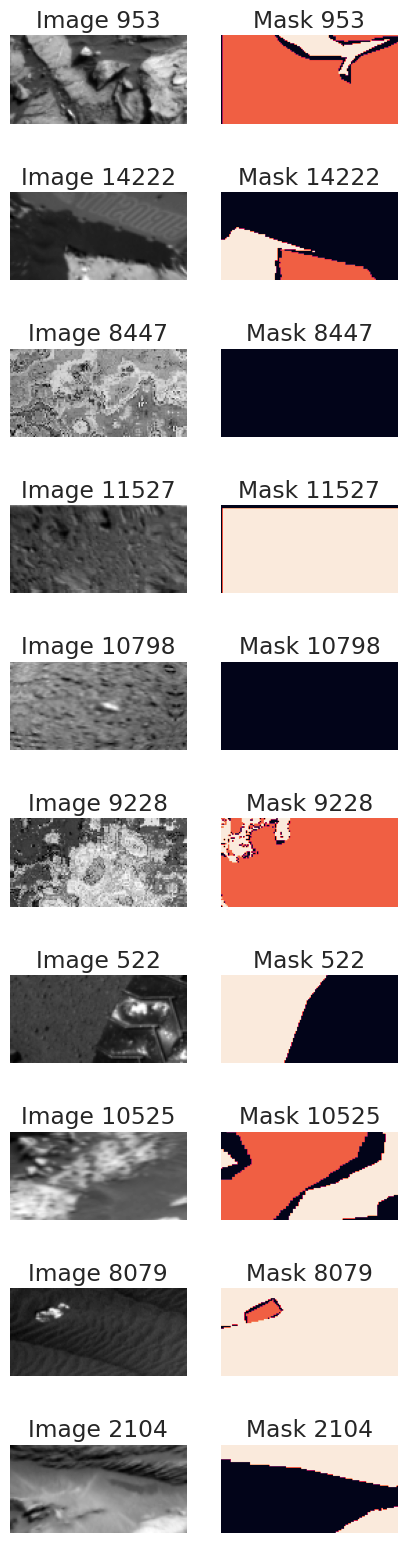

In [16]:
# Select 10 random indices
random_indices = np.random.choice(len(X_train), 10, replace=False)

# Plot the images and their corresponding masks
fig, axes = plt.subplots(10, 2, figsize=(5, 20))
for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(X_train[idx], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {idx}')
    
    axes[i, 1].imshow(y_train[idx])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Mask {idx}')
plt.show()

In [17]:
# Set steps per epoch for training
STEPS_PER_EPOCH = y_train.shape[0] // BATCH_SIZE

In [18]:
# Define the category mapping
category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4,  # Big Rock
}


# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [19]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)

    return image, label

In [20]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [21]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [22]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths)).cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [23]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Model

In [24]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [25]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=4, dropout_rate=0.0, l2_reg=0.0, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, Activation, and optional Dropout layers
    for i in range(stack):
        x = tfkl.Conv2D(
            filters, 
            kernel_size=kernel_size, 
            padding='same', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg), 
            name=name + 'conv' + str(i + 1)
        )(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        
        # Apply Dropout if specified
        if dropout_rate > 0:
            x = tfkl.Dropout(rate=dropout_rate, name=name + 'dropout' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [26]:
def attention_gate(skip_connection, gating_signal, filters, name=''):
    """Implements an Attention Gate for a skip connection."""
    # 1x1 convolution to reduce dimensionality of the skip connection
    theta_x = tfkl.Conv2D(filters, kernel_size=1, strides=1, padding='same', name=name + 'theta_x')(skip_connection)

    # 1x1 convolution to reduce dimensionality of the gating signal
    phi_g = tfkl.Conv2D(filters, kernel_size=1, strides=1, padding='same', name=name + 'phi_g')(gating_signal)

    # Add skip connection and gating signal, followed by activation
    add = tfkl.Add(name=name + 'add')([theta_x, phi_g])
    act = tfkl.Activation('relu', name=name + 'relu')(add)

    # 1x1 convolution to produce attention weights
    psi = tfkl.Conv2D(1, kernel_size=1, strides=1, padding='same', name=name + 'psi')(act)
    psi = tfkl.Activation('sigmoid', name=name + 'sigmoid')(psi)

    # Apply attention weights to the skip connection
    attention_output = tfkl.Multiply(name=name + 'multiply')([skip_connection, psi])
    
    return attention_output

In [27]:
def get_unet_model(
    input_shape=(64, 128, 1),
    num_classes=NUM_CLASSES,
    num_levels=2,
    initial_filters=32,
    seed=42,
    dropout_rate=0.3,
    l2_reg=1e-4
):
    """
    Creates a U-Net model with configurable depth and filter counts.
    
    Args:
        input_shape: Tuple of input image dimensions (height, width, channels)
        num_classes: Number of output classes
        num_levels: Number of downsampling/upsampling levels in the U-Net
        initial_filters: Number of filters in the first level (doubles at each level)
        seed: Random seed for reproducibility
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization factor
    
    Returns:
        tf.keras.Model: Configured U-Net model
    """
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    # Store the downsampling blocks for skip connections
    down_blocks = []
    
    # Downsampling path
    x = input_layer
    for level in range(num_levels):
        num_filters = initial_filters * (2**level)
        down_block = unet_block(
            x, 
            num_filters, 
            dropout_rate=dropout_rate, 
            l2_reg=l2_reg, 
            name=f'down_block{level+1}_'
        )
        down_blocks.append(down_block)
        x = tfkl.MaxPooling2D()(down_block)
    
    # Bottleneck
    bottleneck = unet_block(
        x,
        initial_filters * (2**num_levels),
        dropout_rate=dropout_rate,
        l2_reg=l2_reg,
        name='bottleneck'
    )
    
    # Upsampling path
    x = bottleneck
    for level in range(num_levels-1, -1, -1):
        num_filters = initial_filters * (2**level)
        x = tfkl.UpSampling2D()(x)
        a = attention_gate(down_blocks[level], x, num_filters, name=f'attention_block{num_levels-level+1}_')
        x = tfkl.Concatenate()([x, a])
        x = unet_block(
            x,
            num_filters,
            dropout_rate=dropout_rate,
            l2_reg=l2_reg,
            name=f'up_block{level+1}_'
        )
    
    # Output Layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding='same',
        activation="softmax",
        name='output_layer'
    )(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

reduceLROnPlateau = CustomReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)

plot_callback = RealTimePlot()

## Trainning

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv3 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn3   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv4 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn4   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   - 

 Total params: 971,751 (3.71 MB)

 Trainable params: 969,191 (3.70 MB)

 Non-trainable params: 2,560 (10.00 KB)

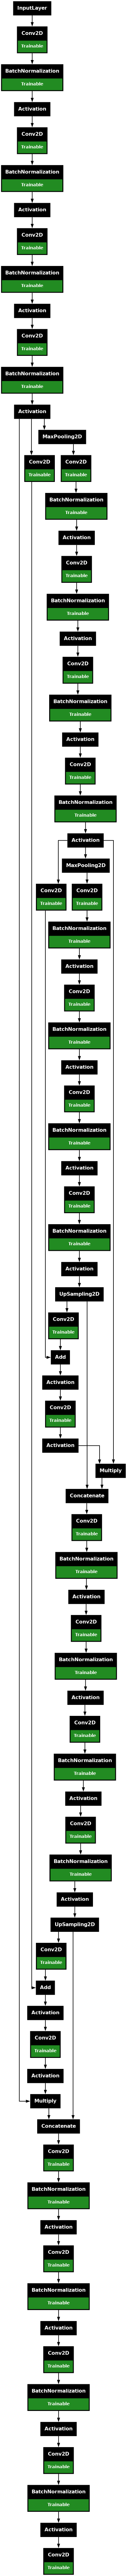

In [29]:
num_levels=2
initial_filters=32
dropout_rate=0
l2_reg=0

with strategy.scope():
    model = get_unet_model(
        num_levels=num_levels,
        initial_filters=initial_filters,
        seed=42,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    )

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [30]:
# Compile the model
print("Compiling model...")
with strategy.scope():
    model.compile(
        #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.AdamW(),
        metrics= ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])] if numTPU == 0 else ["accuracy"]
    )
print("Model compiled!")

Compiling model...
Model compiled!


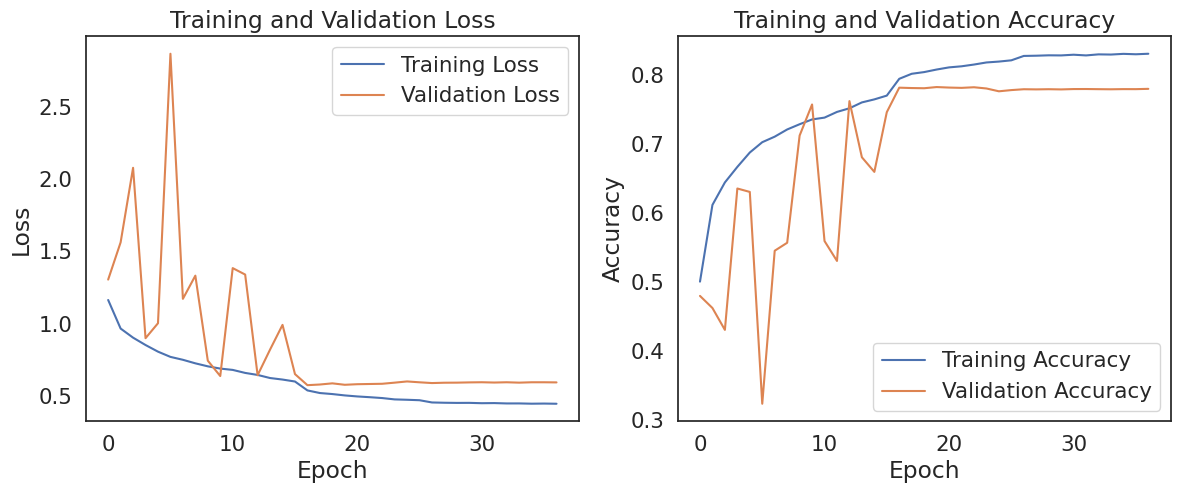

536/536 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.8370 - loss: 0.4297 - mean_iou: 0.5076 - val_accuracy: 0.7798 - val_loss: 0.5932 - val_mean_iou: 0.4718


In [31]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    # steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping, reduceLROnPlateau, plot_callback, VizCallback(X_val[0], y_val[0])],
    shuffle = True,
    verbose=1
).history

In [32]:
def iou (model, X_val, y_val):
    mean_iou = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=-1)
    mean_iou.update_state(y_val, y_pred, sample_weight=None)

    return mean_iou.result().numpy()

In [33]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2) if numTPU == 0 else iou(model, X_val, y_val)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

with strategy.scope():
    # Save the trained model to a file with the accuracy included in the filename
    model_filename = 'UNet_'+str(final_val_meanIoU)+'.weights.h5'
    model.save_weights(model_filename)

Final validation Mean Intersection Over Union: 47.83%


## Predict

In [34]:
test_path = "/kaggle/input/marssoil/mars_for_students.npz"

test_data = np.load(test_path)
X_test = test_data["test_set"]

X_test = X_test[..., np.newaxis] / 255.0

print(f"Input shape: {input_shape}")

Input shape: (64, 128, 1)


In [35]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
Predictions shape: (10022, 64, 128)


In [36]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [37]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}??.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)